## Program Goals ##

Use image dimensions and z to select galaxies in each field of view.

display NSA catalog

show footprint of each halpha image

count number of galaxies in each pointing for which we could detect Halpha

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
%matplotlib inline


//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [230]:
def drawbox(data,style):#feed in center x,y,dx,dy,rotation E of N
    #xcoords of unrotated box, going around CCW
    xl=np.array([data[0]-0.5*data[2],data[0]+0.5*data[2],data[0]+0.5*data[2],data[0]-0.5*data[2],data[0]-0.5*data[2]],'d')
    yl=np.array([data[1]-0.5*data[3],data[1]-0.5*data[3],data[1]+0.5*data[3],data[1]+0.5*data[3],data[1]-0.5*data[3] ],'d')

    xl=np.array([-0.5*data[2],+0.5*data[2],+0.5*data[2],-0.5*data[2],-0.5*data[2]],'d')
    yl=np.array([-0.5*data[3],-0.5*data[3],+0.5*data[3],+0.5*data[3],-0.5*data[3] ],'d')

    ang=np.radians(data[4])#convert rotation to radians
    #rotate coordinates
    xp=np.cos(ang)*xl-np.sin(ang)*yl
    yp=np.sin(ang)*xl+np.cos(ang)*yl

    #put back on absolute scale
    xp=data[0]+xp
    yp=data[1]+yp
    #draw rotated box
    plt.plot(xp,yp,style)

In [291]:
# need to add MKW8, MKW10
# need to check to see who owns WBL 586
# need to check to see who owns NRGs338
# NRGs338 = RASSCALS NRGs338
clusternames=['MKW11','Coma', 'A1367', 'MKW8','MKW10','NRGs338','NRGb004','WBL586']#,'HCG079',]#,'NRGb005']

clusterRA={'WBL586':236.5557,'MKW8':220.15917 ,'MKW10':175.5449,'MKW11':202.3800,'Coma':194.9531, 'A1367':176.1231,'HCG079':239.79945,'NRGs338':229.35875,'NRGb004':129.54792 }

clusterDec={'WBL586':2.4120,'MKW8':3.47639, 'MKW10':10.3059 ,'MKW11':11.78861, 'Coma':27.9807, 'A1367':19.8391,'HCG079':20.75855,'NRGs338':12.90639,'NRGb004':25.11667}

clustervel={'MKW8':8094. ,'MKW10':6158.,'MKW11':6854., 'Coma':6925., 'A1367':6595., 'HCG079':4347.,'NRGs338':8406, 'NRGb004':8478.,'WBL586':3831.}

clustersigma={'WBL586':500.,'MKW11':361, 'Coma':1054., 'A1367':838., 'HCG079':400,'NRGs338':400., 'MKW8':443.,'MKW10':500,'NRGb004':500.}

halpha_filter={'WBL586':8,'MKW8':16 ,'MKW10':12,'MKW11':16,'Coma':16, 'A1367':12,'HCG079':4,'NRGs338':4,'NRGb004':4}
filter_center={4:6618,8:6658,12:6700,16:6742}
filter_width=60.

## Coordinates of Halpha Images

In [311]:
## HDI POINTINGS
# ramin ramax decmin decmax
hdi_wbl586 = ['WBL586-H01',236.171625,236.71778333, 2.34, 2.81271778]
hdi_nrgs338 = ['NRGs338-H01',229.17432083, 229.6878875,12.69315278, 13.20087222]
hdi_mkw11 = ['MKW11-H01',200.68310417, 201.21239167,13.67049722, 14.1613111]
hdi_coma = ['Coma-H01',194.45995, 195.00909583,27.22202222, 28.01033611]
hdi_a1367_01 = ['A1367-H01',175.8049125, 176.32145,19.63918611, 20.12146389]
hdi_a1367_02 = ['A1367-H02',176.29458333, 176.81375,19.36791111, 19.83848611]
hdi_a1367_03 = ['A1367-H03',175.430625, 175.9528875, 19.80565556, 20.28091389]
hdi_nrgb004 = ['NRGb004',129.275804167,129.817691667, 24.8260166667,25.3156194444]
hdi_pointings_dict = {'WBL586':[hdi_wbl586],'NRGs338':[hdi_nrgs338],'MKW11':[hdi_mkw11],'Coma':[hdi_coma],'NRGb004':[hdi_nrgb004],'A1367':[hdi_a1367_01,hdi_a1367_02,hdi_a1367_03]}
hdi_pointings = [hdi_nrgs338,hdi_mkw11,hdi_coma,hdi_a1367_01,hdi_a1367_02,hdi_a1367_03,hdi_nrgb004,hdi_wbl586]

In [293]:
## MOSAIC POINTINGS
# ramin ramax decmin decmax
mkw8 = ['MKW8-M01',219.72952, 220.75088, 3.0029324,4.0424362]
mkw10_02 = ['MKW10-M02',175.68557, 176.7224,8.9617943, 10.026808]
mkw11_01 = ['MKW11-M01',201.71127, 202.76149, 10.84194, 11.887272]
mkw11_02 = ['MKW11-M02',201.45818, 202.50511,11.838808, 12.890766]

mosaic_pointings = [mkw8,mkw10_02,mkw11_01,mkw11_02]
mosaic_pointings_dict = {'MKW8':[mkw8],'MKW10':[mkw10_02],'MKW11':[mkw11_01,mkw11_02]}

In [294]:
# read in NSA catalog
nsapath = '/Users/rfinn/research/NSA/NSA_LCSregion.fits'
nsapath = '/Users/rfinn/research/NSA/nsa_v0_1_2.fits'
nsa = fits.getdata(nsapath)

In [314]:
# get Halpha emitters in HDI fields
ha_emitters = [] # NSA ID of emitters
ha_extended = []
infile = open('cutout-list-09Sep2016','r')
for line in infile:
    if line.find('emission') > -1: # get names of emitters
        t = line.split('-')
        ha_emitters.append(t[1])
    if line.find('extended') > -1: # get names of emitters
        t = line.split('-')
        ha_extended.append(t[1])
infile.close()
print 'number of halpha emitters in HDI fields = ',len(ha_emitters)

nsadict = dict((a,b) for a,b in zip(nsa.NSAID,np.arange(len(nsa.NSAID))))
ha_flag = np.zeros(len(nsa.RA),'bool')
ha_extended_flag = np.zeros(len(nsa.RA),'bool')
for h in ha_emitters:
    ha_flag[nsadict[int(h)]] = True
for h in ha_extended:
    ha_extended_flag[nsadict[int(h)]] = True

number of halpha emitters in HDI fields =  52


In [296]:
sum(ha_flag)

57

no text for Coma


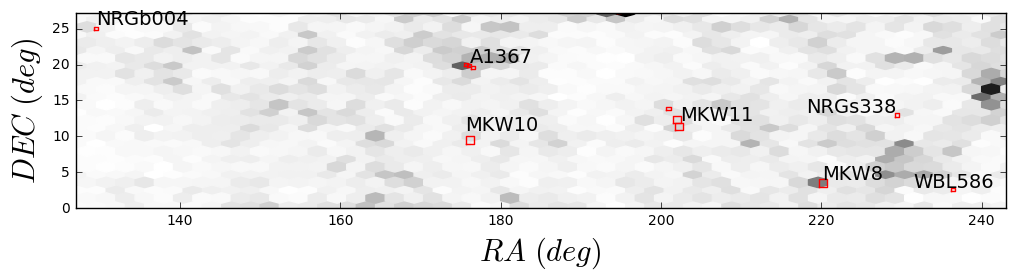

In [304]:
plt.figure(figsize=(12,3))
zflag = (nsa.Z > 0.01) & (nsa.Z < .043)
plt.hexbin(nsa.RA[zflag],nsa.DEC[zflag],gridsize=(150,50),cmap='gray_r')
pointings = hdi_pointings + mosaic_pointings
for cl in clusternames:
    #plt.plot(clusterRA[cl],clusterDec[cl],'rx',markersize=10)
    if (cl.find('NRGs') > -1):
        plt.text(clusterRA[cl],clusterDec[cl]+.5,cl,fontsize=14,horizontalalignment='right')
    elif (cl.find('WBL') > -1):
        plt.text(clusterRA[cl],clusterDec[cl]+.5,cl,fontsize=14,horizontalalignment='center')
    elif cl.find('Coma') > -1:
        print 'no text for Coma'
    else:
        plt.text(clusterRA[cl],clusterDec[cl]+.5,cl,fontsize=14,horizontalalignment='left')
for p in pointings:
    drawbox([(p[1]+p[2])/2.,(p[3]+p[4])/2., (p[2]-p[1]),(p[4]-p[3]),0],'r-')
plt.axis([127,243,0,27.2])
plt.subplots_adjust(bottom=.25)
#plt.axis([200,204,10,15])
plt.xlabel('$RA \ (deg) $',fontsize=22)
plt.ylabel('$DEC \ (deg) $',fontsize=22)
plt.savefig('/Users/rfinn/research/HalphaGroups/plots/fov.png')

In [256]:
8*15

120

## For next time (10/26)  ##

* finalize dimensions of Halpha HDI pointings
* add MOSAIC pointings
* read papers on how to measure sizes
    * boselli papers
    
    
## Goals for AAS ##
* how many members are in the field of view
* how many do we detect in Halpha
* make a plot of fraction of Halpha detections versus stellar mass, B/T
* measure Halpha sizes for cluster/group - compare to Virgo, Field
* SFRs
* calculate consumption times for those with HI measurements




## Miscellaneous Notes ##

**Using astropy coordinate functions**

In [242]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [243]:
c1 = SkyCoord('15h58m13.2','12d20m15.0',frame='icrs')
print c1
print '########'
print c1.ra.deg, c1.dec.deg
# NRGb004 - convert images dimensions from hhmmss to deg
lower_left = SkyCoord('8h37m06.193','24d49m33.66',frame='icrs')
upper_right = SkyCoord('8h39m16.246','25d18m56.23',frame='icrs')
print lower_left.ra.deg,upper_right.ra.deg
print lower_left.dec.deg,upper_right.dec.deg

<SkyCoord (ICRS): (ra, dec) in deg
    (239.555, 12.3375)>
########
239.555 12.3375
129.275804167 129.817691667
24.8260166667 25.3156194444


## What do we want to do?

* create a catalog for each cluster that contains galaxies that
    * are in the right velocity range
    * within the FOV
    * record the pointing number
    * record the camera (HDI/mosaic)
    

In [357]:
class cluster:
    def __init__(self,clname):
        self.prefix = clname
        self.cra = clusterRA[clname]
        self.cdec = clusterDec[clname]
        self.vcenter = clustervel[clname]
        self.sigma = clustersigma[clname]
        self.hafilter = halpha_filter[clname]
        
        self.filter_center = filter_center[self.hafilter]
        self.filter_width = filter_width
        self.filter_vcenter=(filter_center[self.hafilter]/6563. -1)*3.e5
        self.filter_vmin=((self.filter_center-0.5*self.filter_width)/6563. -1)*3.e5
        self.filter_vmax=((self.filter_center+0.5*self.filter_width)/6563. -1)*3.e5

        self.group_vmin=self.vcenter-3.*self.sigma
        self.group_vmax=self.vcenter+3.*self.sigma
        self.dr_flag = np.sqrt((nsa.RA -self.cra)**2 + (nsa.DEC - self.cdec)**2) < 3.
        self.membflag = (nsa.Z*3.e5 > self.group_vmin) & (nsa.Z*3.e5 < self.group_vmax) & self.dr_flag
        self.get_sample(verbose=True)
        
        self.ha_detection = self.fov_flag & ha_flag
        self.ha_extended = self.fov_flag & ha_flag & ha_extended_flag
        a = np.sum(self.ha_extended)
        b = np.sum(self.ha_detection)
        if b > 0.:
            print 'fraction of ha emitters that are extended = %.2f (%i/%i)'%(1.*a/b,a,b)
        
    def get_sample(self,verbose=True):
        '''
        get galaxies that are on the Halpha footprint and in the right
        velocity range so that we can detect Halpha
        '''
        # select galaxies with redshift within Halpha filter window
        self.vfilter_flag = (nsa.Z*3.e5 > self.filter_vmin) & (nsa.Z*3.e5 < self.filter_vmax) 
        # keep galaxies within Halpha FOV
        self.fov_flag = np.zeros(len(nsa.RA),'bool')
        pointings_list = []
        try:
            pointings_list = pointings_list+hdi_pointings_dict[self.prefix]
        except KeyError:
            if verbose:
                print 'no HDI pointings for ',self.prefix
        try:
            pointings_list = pointings_list+mosaic_pointings_dict[self.prefix]
        except KeyError:
            if verbose:
                print 'no Mosaic pointings for ',self.prefix
            
        for pointing in pointings_list:
            
            t = ((nsa.RA > pointing[1]) & (nsa.RA < pointing[2]) & (nsa.DEC > pointing[3]) & (nsa.DEC < pointing[4]))
            if verbose:
                print 'Pointing name = ',pointing[0]
                print '\t number of galaxies in this FOV and with right recession velocity = ',sum(t & self.vfilter_flag)
            self.fov_flag = self.fov_flag | t
                                             
        
        #print 'number of galaxies in the FOV = ',sum(self.fov_flag)
        #print 'number of galaxies in the velocity window', sum(self.vfilter_flag)
        if verbose:
            print 'Total number of galaxies in FOV and filter window = ',sum(self.fov_flag & self.vfilter_flag)
    
    
    def plot_FOV(self):
        if self.prefix == 'A1367':
            plt.figure(figsize=(10,8))
        else:
            plt.figure(figsize=(6,5))
        #plt.hexbin(nsa.RA,nsa.DEC,gridsize=200,cmap='gray_r')
        pointings = hdi_pointings_dict[self.prefix] #+ mosaic_pointings

        plt.title('$'+self.prefix+'$',fontsize=20)
        for p in pointings:
            drawbox([(p[1]+p[2])/2.,(p[3]+p[4])/2., (p[2]-p[1]),(p[4]-p[3]),0],'r-')
        plt.plot(self.cra,self.cdec,'kx',markersize=20)
        flag = self.membflag & self.fov_flag & ~ha_flag
        plt.plot(nsa.RA[flag],nsa.DEC[flag],'k^',label='$No \ H-alpha$')
        flag = self.membflag & self.fov_flag & self.ha_detection
        plt.plot(nsa.RA[flag],nsa.DEC[flag],'bo',label='$H-alpha$',markersize=8, )
        flag = self.membflag & self.fov_flag & self.ha_detection & self.ha_extended
        plt.plot(nsa.RA[flag],nsa.DEC[flag],'bo',label='$Extended \ Ha$',markersize=15)
        #plt.axis([170,245,0,30])
        #plt.axis([200,204,10,15])
        plt.xlabel('$RA \ (deg) $',fontsize=20)
        plt.ylabel('$DEC \ (deg) $',fontsize=20)
        plt.legend(loc='upper right',numpoints=1)
        plt.savefig('/Users/rfinn/Dropbox/Research/HalphaGroups/plots/'+self.prefix+'-positions.png')
    def plot_colormag(self):
        plt.figure()
        #plt.plot(nsa.ABSMAG[:,4],nsa.ABSMAG[:,1]-nsa.ABSMAG[:,4],'k.',color='0.7')
        plt.hexbin(nsa.ABSMAG[:,4],nsa.ABSMAG[:,1]-nsa.ABSMAG[:,4],gridsize=250,cmap='gray_r')
        plt.axis([-23,-15.5,0.,7.5])
        flag = self.membflag & self.fov_flag & ~self.ha_detection
        plt.plot(nsa.ABSMAG[:,4][flag],nsa.ABSMAG[:,1][flag]-nsa.ABSMAG[:,4][flag],'r^',label='$In \ FOV$')
        flag = self.membflag & self.fov_flag & self.ha_detection
        plt.plot(nsa.ABSMAG[:,4][flag],nsa.ABSMAG[:,1][flag]-nsa.ABSMAG[:,4][flag],'bo',label='$H-alpha $')
        plt.title('$'+self.prefix+'$',fontsize=20)
        plt.xlabel('$M_r $',fontsize=20)
        plt.ylabel('$NUV-r $',fontsize=20)
        plt.legend(numpoints=1,loc='lower left')
        #plt.axhline(y=4,ls='--',color='k')
        #plt.axhline(y=4.9,ls=':',color='k')
        plt.savefig('/Users/rfinn/Dropbox/Research/HalphaGroups/plots/'+self.prefix+'-colormag.png')


   
#flag = (dist < dr) & (agcvopt > groupfiltvmin[i]) & (agcvopt < groupfiltvmax[i])
#flagHI = (dist < dr) & (agcvopt > groupfiltvmin[i]) & (agcvopt < groupfiltvmax[i]) & (agcflux100 > 0.)
#flagmemb = (dist < dr) & (agcvopt > groupvmin[i]) & (agcvopt < groupvmax[i]) & flag
#flagspiral=(dist < dr) & (agctype > 99) & (agctype < 183) & (absmag < -18) & (agcvopt > groupfiltvmin[i]) & (agcvopt < groupfiltvmax[i])
#flagspiral2=(dist < dr) & (agctype > 299) & (agctype < 313) & (absmag < -18) & (agcvopt > groupfiltvmin[i]) & (agcvopt < groupfiltvmax[i])

no Mosaic pointings for  WBL586
Pointing name =  WBL586-H01
	 number of galaxies in this FOV and with right recession velocity =  5
Total number of galaxies in FOV and filter window =  5
fraction of ha emitters that are extended = 1.00 (4/4)
no Mosaic pointings for  NRGb004
Pointing name =  NRGb004
	 number of galaxies in this FOV and with right recession velocity =  0
Total number of galaxies in FOV and filter window =  0
fraction of ha emitters that are extended = 0.38 (3/8)
no Mosaic pointings for  NRGs338
Pointing name =  NRGs338-H01
	 number of galaxies in this FOV and with right recession velocity =  0
Total number of galaxies in FOV and filter window =  0
fraction of ha emitters that are extended = 0.40 (2/5)
no Mosaic pointings for  A1367
Pointing name =  A1367-H01
	 number of galaxies in this FOV and with right recession velocity =  50
Pointing name =  A1367-H02
	 number of galaxies in this FOV and with right recession velocity =  36
Pointing name =  A1367-H03
	 number of gala

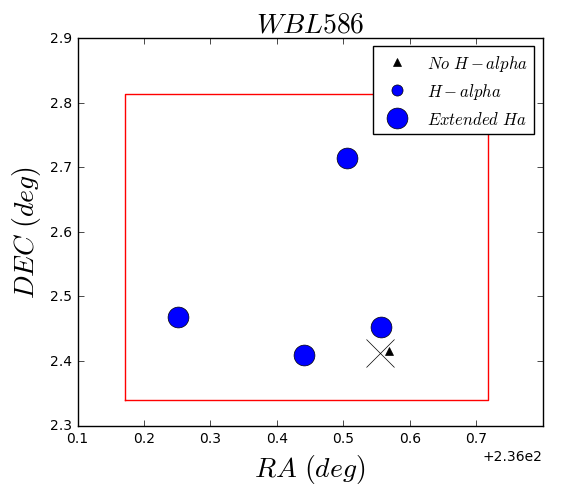

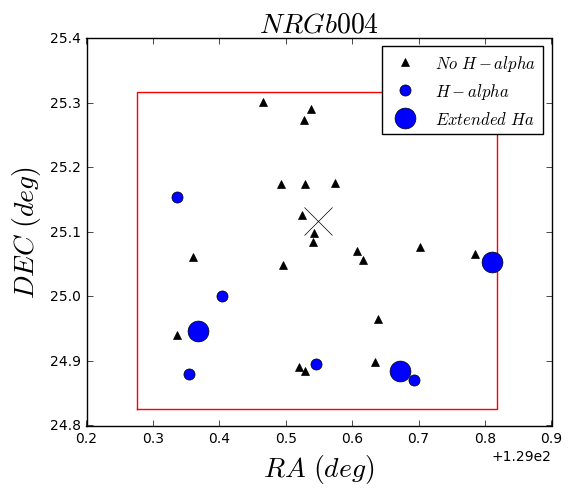

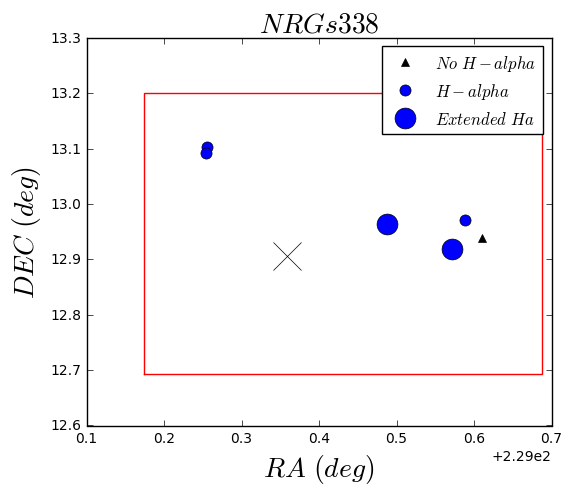

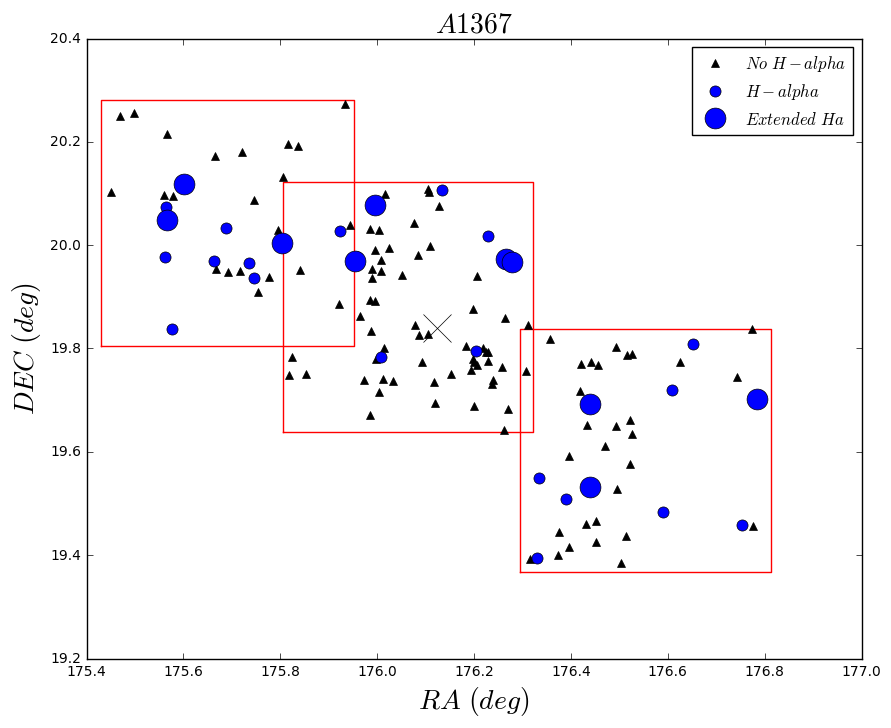

In [358]:

clusters = ['WBL586','NRGb004','NRGs338','A1367']
for c in clusters:
    cl = cluster(c)
    cl.plot_FOV()

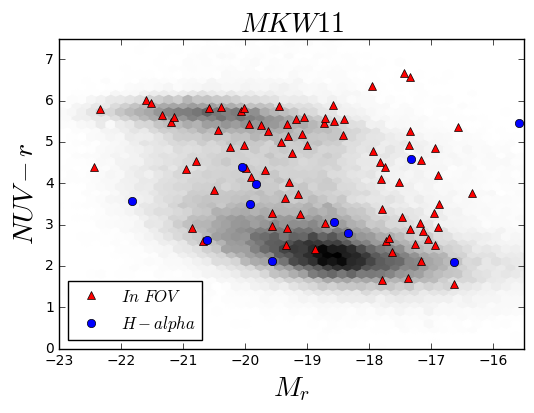

In [277]:
mkw11.plot_colormag()
#print mkw11.filter_vmin

Pointing name =  MKW11-H01
	 number of galaxies in this FOV and with right recession velocity =  14
Pointing name =  MKW11-M01
	 number of galaxies in this FOV and with right recession velocity =  27
Pointing name =  MKW11-M02
	 number of galaxies in this FOV and with right recession velocity =  16
Total number of galaxies in FOV and filter window =  56
no Mosaic pointings for  Coma
Pointing name =  Coma-H01
	 number of galaxies in this FOV and with right recession velocity =  94
Total number of galaxies in FOV and filter window =  94
no Mosaic pointings for  A1367
Pointing name =  A1367-H01
	 number of galaxies in this FOV and with right recession velocity =  50
Pointing name =  A1367-H02
	 number of galaxies in this FOV and with right recession velocity =  36
Pointing name =  A1367-H03
	 number of galaxies in this FOV and with right recession velocity =  31
Total number of galaxies in FOV and filter window =  114
fraction of ha emitters that are extended = 0.33 (10/30)
no HDI pointin

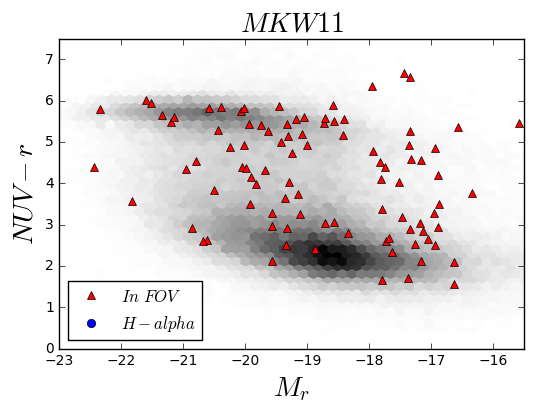

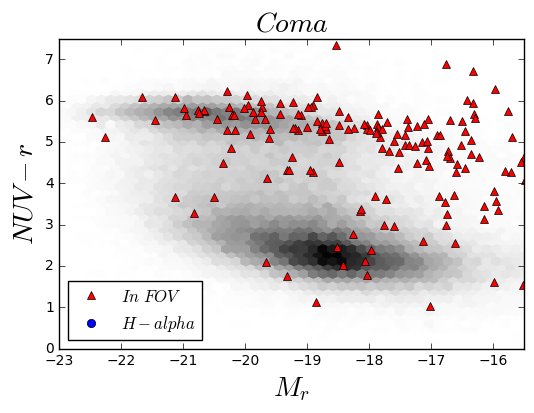

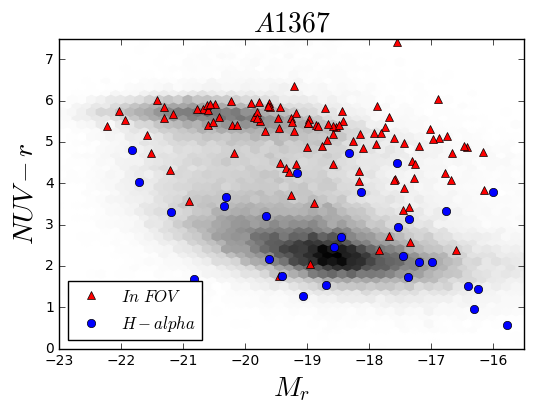

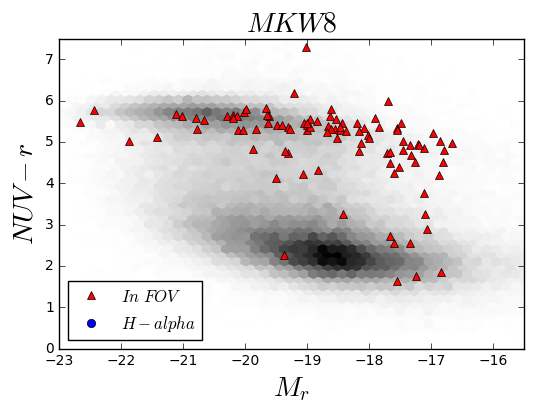

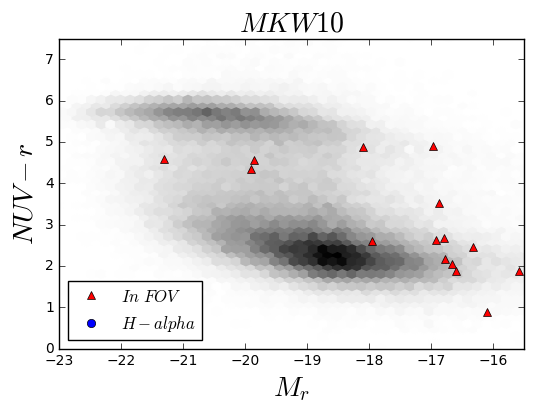

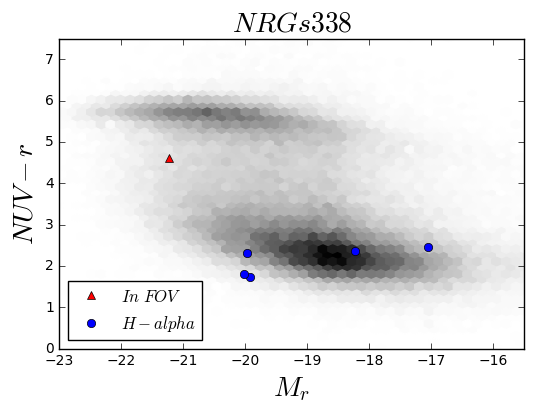

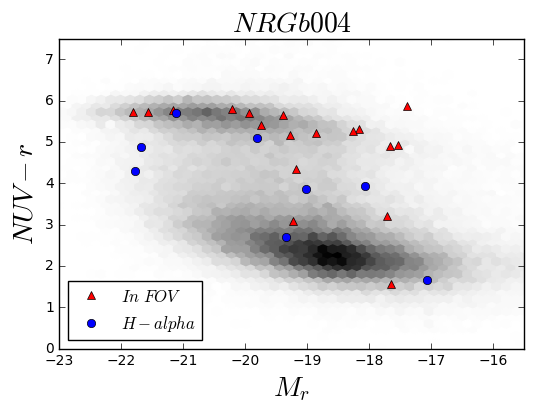

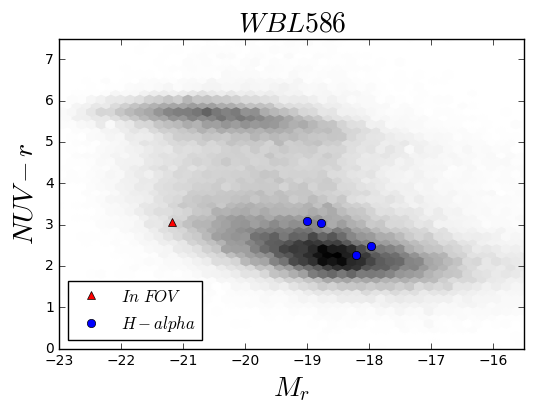

In [318]:
for cl in clusternames:
    c = cluster(cl)
    c.plot_colormag()

In [ ]:
for cl in clusternames:
    plt.figure()
    plt.subplots(1,2,1)
    plt.scatter(ra[flag],dec[flag],s=(20-agcmag10[flag]/10)*20+20,color='.8')
    plt.plot(ra[flagmemb],dec[flagmemb],'g^', alpha=0.3,markersize=14)
    plt.plot(ra[flagspiral],dec[flagspiral],'r*',alpha=0.3,markersize=14)
    plt.plot(ra[flagspiral2],dec[flagspiral2],'r*',alpha=0.3,markersize=14)
    plt.plot(ra[flag],dec[flag],'k.')


    plot(ra[flagHI],dec[flagHI],'bo', markerfacecolor='None',markeredgecolor='b',markersize=8)
    plot(ra[flag],dec[flag],'k.')
    plot(grouprac[i],groupdecc[i],'rx',markersize=10,lw=3)#mark cluster center with a red x


    mytitle=groupnames[i]+', '+altgroupnames[i]
    title(mytitle,fontsize=24)
    xlabel('RA (deg)',fontsize=18)
    ylabel('Dec (deg)',fontsize=18)
    axis([grouprac[i]+dr,grouprac[i]-dr,groupdecc[i]-dr,groupdecc[i]+dr])
    axis('equal')
    #axis(groupra[i]+dr,[groupra[i]-dr,groupdec[i]-dr,groupdec[i]+dr])
    s=groupnames[i]+'.png'
    print i,s
    if makesubplots:
        subplot(1,2,2)
    else:
        savefig(s)
        figure()    
    # make a histogram 
    hist(agcvopt[flagmemb],bins=20)
    axvline(x=groupvel[i],color='r')
    axvline(x=groupfiltvmax[i],color='r',ls='--')
    axvline(x=groupfiltvmin[i],color='r',ls='--')
    if subplots:
        savefig(s)